# Fine Tuning Roberta for Sentiment Analysis





In [ ]:
!pip install transformers
!pip install comet_ml

In [2]:
def set_experiment(api_key, project_name, workspace):
    experiment = Experiment(
    api_key=api_key,
    project_name=project_name,
    workspace=workspace
)
    
    return experiment

In [ ]:
import comet_ml
from comet_ml import Experiment

api_key = xxx
project_name = xxx
workspace = xxx

experiment = set_experiment(api_key, project_name, workspace)

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
from copy import deepcopy

import tqdm
import torch
import transformers
from torch import cuda
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer

In [5]:
def log_parameters(experiment, hyper_params):
    experiment.log_parameter("train_batch_size", hyper_params['batch_size'])
    experiment.log_parameter("test_batch_size", hyper_params['batch_size'])

    experiment.log_parameter("Learning Rate", hyper_params['lr'])
    experiment.log_parameter("general_epochs", hyper_params['epochs'])
    experiment.log_parameter("lr_decay", hyper_params['lr_decay'])
    experiment.log_parameter("max_len", hyper_params['max_len'])

In [6]:
X_train = pd.read_csv('train.csv', header=0)
X_dev = pd.read_csv('dev.csv', header=0)
X_test = pd.read_csv('test.csv', header=0)

<a id='section03'></a>
### Preparing the Dataset and Dataloader

In [ ]:
parameters = { 'max_len'    : 256,
               'batch_size' : 32,
               'epochs'     : 10,
               'lr'         : 5e-5,
               'lr_decay'   : 0.2
             }

tokenizer = RobertaTokenizer.from_pretrained('blinoff/roberta-base-russian-v0', truncation=True, do_lower_case=True)
device = 'cuda' if cuda.is_available() else 'cpu'

In [8]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text = dataframe.Text
        self.targets = dataframe.Class
        self.max_len = max_len

    def __len__(self):
        return len(self.comment_text)

    def __getitem__(self, index):
        comment_text = str(self.comment_text[index])
        comment_text = " ".join(comment_text.split())

        inputs = self.tokenizer.encode_plus(
            comment_text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [9]:
train_set = CustomDataset(X_train, tokenizer, parameters['max_len'])
val_set = CustomDataset(X_dev, tokenizer, parameters['max_len'])
test_set = CustomDataset(X_test, tokenizer, parameters['max_len'])

In [10]:
train_params = {'batch_size': parameters['batch_size'],
                'shuffle': True,
                'num_workers': 0
                }

val_params = {'batch_size': parameters['batch_size'],
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': parameters['batch_size'],
                'shuffle': False,
                'num_workers': 0
                }

train_loader = DataLoader(train_set, **train_params)
val_loader = DataLoader(val_set, **val_params)
test_loader = DataLoader(test_set, **test_params)

<a id='section04'></a>
### Creating the Neural Network for Fine Tuning


In [11]:
class RobertaClass(torch.nn.Module):
    def __init__(self):
        super(RobertaClass, self).__init__()
        self.l1 = RobertaModel.from_pretrained("blinoff/roberta-base-russian-v0")
        self.pre_classifier = torch.nn.Linear(768, 256)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(256, 3)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [12]:
log_parameters(experiment, parameters)

In [ ]:
model = RobertaClass()
model.to(device)

experiment.set_model_graph(model, True)

<a id='section05'></a>
### Fine Tuning the Model

In [14]:
from torch.optim.lr_scheduler import StepLR

In [15]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=parameters['lr'], eps=1e-8)
lr_scheduler = StepLR(optimizer, step_size=4, 
                      gamma=parameters['lr_decay'], verbose=True)

Adjusting learning rate of group 0 to 5.0000e-05.


In [16]:
def calcuate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct

In [17]:
def train(model, criterion, optimizer, train_dl, val_dl, epochs, experiment, lr_scheduler: StepLR=None):
    
    train_losses = []
    val_losses = []
    
    best_model_params = deepcopy(model.state_dict())
    best_accuracy = 0.0
    
    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}\n',
              f'{"--------------------" * 4}')
        
        tr_loss, n_correct, nb_tr_steps, nb_tr_examples = 0, 0, 0, 0
        tr_accuracy = 0.0
        
        model.train()
        
        for step, data in enumerate(train_dl):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            
            optimizer.zero_grad()
            outputs = model(ids, mask, token_type_ids)
            loss = criterion(outputs, targets)
            
            tr_loss += loss.item() 
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += calcuate_accuracy(big_idx, targets)
            
            loss.backward()
            optimizer.step()

            nb_tr_steps += 1
            nb_tr_examples += targets.size(0)

            if (step % 100 == 0 and step != 0) or (step == len(train_dl) - 1):
                # Calculate time elapsed for 20 batches
                print(f"{epoch + 1:^7} | {step:^7} |")

            
        train_loss = tr_loss/nb_tr_steps
        train_losses.append(train_loss)
        lr_scheduler.step() 
        tr_accuracy = (n_correct*100)/nb_tr_examples 
        experiment.log_metric('loss_train', train_loss)

        model.eval() 
        
        vl_loss, n_correct, nb_tr_steps, nb_tr_examples = 0, 0, 0, 0 
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for data in val_dl:
                ids = data['ids'].to(device, dtype = torch.long)
                mask = data['mask'].to(device, dtype = torch.long)
                token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
                targets = data['targets'].to(device, dtype = torch.long)

                outputs = model(ids, mask, token_type_ids).squeeze()
                loss = criterion(outputs, targets)

                vl_loss += loss.item() 
                big_val, big_idx = torch.max(outputs.data, dim=1)
                n_correct += calcuate_accuracy(big_idx, targets)

                all_preds += big_idx.tolist()
                all_labels += targets.tolist()

                nb_tr_steps += 1
                nb_tr_examples += targets.size(0)
                
        
        val_loss = vl_loss/nb_tr_steps
        accuracy = (n_correct*100)/nb_tr_examples 
        experiment.log_metric('loss_val', val_loss)

        b_accuracy = balanced_accuracy_score(all_labels, all_preds)
        print('Balanced_accuracy know: ', b_accuracy)
        experiment.log_metric('loss_b_accuracy', b_accuracy)

        val_losses.append(val_loss)
        print(f'Train Loss: {train_loss:.4f} \t Val Loss: {val_loss:.4f} \t  Train Accuracy: {tr_accuracy:.4f} \t Val Accuracy: {accuracy:.4f}\n')
        
        if b_accuracy > best_accuracy:
            best_accuracy = b_accuracy
            best_model_params = deepcopy(model.state_dict())
            
            output_model_file = f'second_robert_sentiment_{round(b_accuracy, 5)}.bin'

            model_to_save = model
            torch.save(model_to_save, output_model_file)
            
    print('Finished Training and the best accuracy is: {:.4f}'.format(best_accuracy))
    return train_losses, val_losses, best_model_params, best_accuracy

In [18]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score

In [19]:
train_losses, val_losses, best_model_params, best_accuracy = train(
                                                                 model, 
                                                                 loss_function, 
                                                                 optimizer, 
                                                                 train_loader, 
                                                                 val_loader, 
                                                                 parameters['epochs'], 
                                                                 experiment,
                                                                 lr_scheduler)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Epoch 1/10
 --------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


   1    |   100   |
   1    |   200   |
   1    |   300   |
   1    |   320   |
Adjusting learning rate of group 0 to 5.0000e-05.
Balanced_accuracy know:  0.6915284568433835
Train Loss: 0.8391 	 Val Loss: 0.6908 	  Train Accuracy: 61.3907 	 Val Accuracy: 69.1498

Epoch 2/10
 --------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


   2    |   100   |
   2    |   200   |
   2    |   300   |
   2    |   320   |
Adjusting learning rate of group 0 to 5.0000e-05.
Balanced_accuracy know:  0.7020721201911884
Train Loss: 0.6403 	 Val Loss: 0.7001 	  Train Accuracy: 74.1077 	 Val Accuracy: 70.2028

Epoch 3/10
 --------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


   3    |   100   |
   3    |   200   |
   3    |   300   |
   3    |   320   |
Adjusting learning rate of group 0 to 5.0000e-05.
Balanced_accuracy know:  0.7250398309069577
Train Loss: 0.4781 	 Val Loss: 0.7559 	  Train Accuracy: 82.4849 	 Val Accuracy: 72.5039

Epoch 4/10
 --------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


   4    |   100   |
   4    |   200   |
   4    |   300   |
   4    |   320   |
Adjusting learning rate of group 0 to 1.0000e-05.
Balanced_accuracy know:  0.7121907683598797
Train Loss: 0.3141 	 Val Loss: 0.8505 	  Train Accuracy: 89.1359 	 Val Accuracy: 71.2168

Epoch 5/10
 --------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


   5    |   100   |
   5    |   200   |
   5    |   300   |
   5    |   320   |
Adjusting learning rate of group 0 to 1.0000e-05.
Balanced_accuracy know:  0.7168714135064437
Train Loss: 0.1455 	 Val Loss: 1.0253 	  Train Accuracy: 95.1726 	 Val Accuracy: 71.6849

Epoch 6/10
 --------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


   6    |   100   |
   6    |   200   |
   6    |   300   |
   6    |   320   |
Adjusting learning rate of group 0 to 1.0000e-05.
Balanced_accuracy know:  0.7005017096475251
Train Loss: 0.1052 	 Val Loss: 1.1504 	  Train Accuracy: 96.5769 	 Val Accuracy: 70.0468

Epoch 7/10
 --------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


   7    |   100   |
   7    |   200   |
   7    |   300   |
   7    |   320   |
Adjusting learning rate of group 0 to 1.0000e-05.
Balanced_accuracy know:  0.7102528634884114
Train Loss: 0.0822 	 Val Loss: 1.2878 	  Train Accuracy: 97.3474 	 Val Accuracy: 71.0218

Epoch 8/10
 --------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


   8    |   100   |
   8    |   200   |
   8    |   300   |
   8    |   320   |
Adjusting learning rate of group 0 to 2.0000e-06.
Balanced_accuracy know:  0.6985537614528123
Train Loss: 0.0658 	 Val Loss: 1.3629 	  Train Accuracy: 97.7180 	 Val Accuracy: 69.8518

Epoch 9/10
 --------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


   9    |   100   |
   9    |   200   |
   9    |   300   |
   9    |   320   |
Adjusting learning rate of group 0 to 2.0000e-06.
Balanced_accuracy know:  0.6966026176552492
Train Loss: 0.0487 	 Val Loss: 1.5264 	  Train Accuracy: 98.4006 	 Val Accuracy: 69.6568

Epoch 10/10
 --------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


  10    |   100   |
  10    |   200   |
  10    |   300   |
  10    |   320   |
Adjusting learning rate of group 0 to 2.0000e-06.
Balanced_accuracy know:  0.6969874595413854
Train Loss: 0.0438 	 Val Loss: 1.5411 	  Train Accuracy: 98.6347 	 Val Accuracy: 69.6958

Finished Training and the best accuracy is: 0.7250


<a id='section06'></a>
### Validating the Model


In [20]:
def get_predicts(model, loader):
    
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0; tr_loss=0; nb_tr_steps=0; nb_tr_examples=0
    all_preds, all_labels = [], []
    
    
    with torch.no_grad():
        for _, data in (enumerate(loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            b_labels = data['targets'].to(device, dtype = torch.long)

            logits = model(ids, mask, token_type_ids)
            preds = torch.argmax(logits, dim=1).flatten()

            all_preds += preds.tolist()
            all_labels += b_labels.tolist()

    
    return all_preds, all_labels



In [23]:
model = torch.load('/content/second_robert_sentiment_0.72504.bin')

model.eval()
None

In [ ]:
y_pred_test, y_test = get_predicts(model, test_loader)
y_pred_train, y_train = get_predicts(model, train_loader)
y_pred_val, y_val = get_predicts(model, val_loader)

In [25]:
def statistic(y_pred_test, y_test, y_pred_train, y_train,
             t1, t2):
    score_table = pd.DataFrame(columns=(t1, t2))

    b_train = balanced_accuracy_score(y_train, y_pred_train)
    b_test = balanced_accuracy_score(y_test, y_pred_test)
    score_table.loc['balanced_accuracy_score', :] = (b_train, b_test)

    a_train = accuracy_score(y_train, y_pred_train)
    a_test = accuracy_score(y_test, y_pred_test)
    score_table.loc['accuracy_score', :] = (a_train, a_test)

    f1_train = f1_score(y_train, y_pred_train, average='weighted')
    f1_test = f1_score(y_test, y_pred_test, average='weighted')
    score_table.loc['f1 weighted', :] = (f1_train, f1_test)

    f1_train = f1_score(y_train, y_pred_train, average='micro')
    f1_test = f1_score(y_test, y_pred_test, average='micro')
    score_table.loc['f1 micro', :] = (f1_train, f1_test)

    f1_train = f1_score(y_train, y_pred_train, average='macro')
    f1_test = f1_score(y_test, y_pred_test, average='macro')
    score_table.loc['f1 macro', :] = (f1_train, f1_test)

    return score_table

In [26]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt

In [27]:
def cm_plot(y_test, y_pred, y_type):

    cm = confusion_matrix(y_test, y_pred)
    # Normalise
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(cmn, cmap='Blues', annot=True, fmt='.2f')
    sns.set(font_scale=1.3)
    plt.title(f'Confusion Matrix of {y_type}')

    return plt.show()

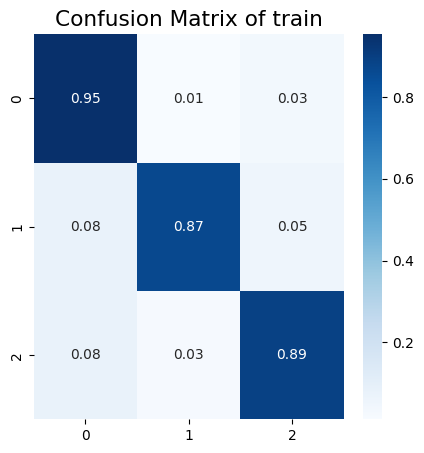

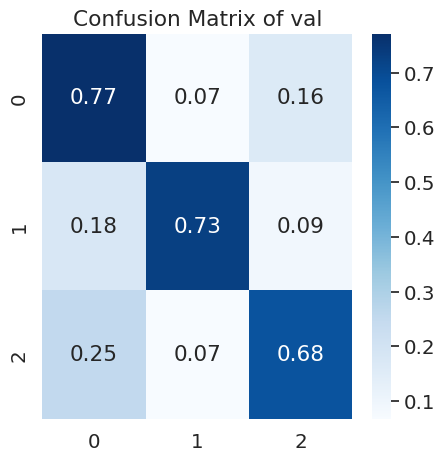

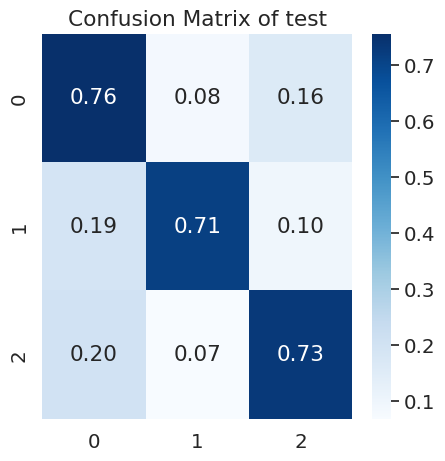

In [28]:
cm_plot(y_train, y_pred_train, 'train')
cm_plot(y_val, y_pred_val, 'val')
cm_plot(y_test, y_pred_test, 'test')

In [29]:
statistic(y_pred_test, y_test, y_pred_train, y_train, 'train', 'test')

,train,test
balanced_accuracy_score,0.905305,0.733235
accuracy_score,0.905305,0.733229
f1 weighted,0.905446,0.734672
f1 micro,0.905305,0.733229
f1 macro,0.905446,0.734662


In [30]:
statistic(y_pred_train, y_train, y_pred_val, y_val, 'dev', 'train')

,dev,train
balanced_accuracy_score,0.72504,0.905305
accuracy_score,0.725039,0.905305
f1 weighted,0.726895,0.905446
f1 micro,0.725039,0.905305
f1 macro,0.726916,0.905446


In [21]:
from google.colab import files
from google.colab import drive

drive.mount("/content/gdrive/")

Mounted at /content/gdrive/


In [22]:
!cp second_robert_sentiment_0.72504.bin xxx

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>